In [67]:
# Fundamental environment setup
import matplotlib
import numpy as np
import psutil
import ray
import seaborn as sns
import copy
import urllib.request
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy.linalg as la
from scipy.sparse import csc_matrix, csr_matrix
from sklearn.datasets import load_svmlight_file, fetch_rcv1

from optmethods.datasets import get_dataset
from optmethods.first_order import Adgd, Gd, Nesterov, RestNest
from optmethods.loss import LogisticRegression
from optmethods.utils import get_trace, relative_round

sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (9, 6)

In [68]:
ray.shutdown()
num_cpus = psutil.cpu_count(logical=False)
ray.init(num_cpus=num_cpus)

RayContext(dashboard_url='', python_version='3.8.12', ray_version='1.12.1', ray_commit='4863e33856b54ccf8add5cbe75e41558850a1b75', address_info={'node_ip_address': '10.68.186.178', 'raylet_ip_address': '10.68.186.178', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-05-26_15-51-59_539713_40717/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-05-26_15-51-59_539713_40717/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-05-26_15-51-59_539713_40717', 'metrics_export_port': 47548, 'gcs_address': '10.68.186.178:62371', 'address': '10.68.186.178:62371', 'node_id': '9229fdc9aeefddc3e79281cac6597db28265f3d240e78a3dbe29c933'})

In [110]:
dataset = 'w8a'
n_workers = 20
regul = 1e-3
com_cost = 1
local_cost = 1000
bs = 64
# bs = 16

In [111]:
data_url = f"https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/{dataset}"
data_path = f"./{dataset}"
print(data_path)
# assert 0
f = urllib.request.urlretrieve(data_url, data_path)
# f = urllib.request.urlretrieve(a9a_url, data_path)
A, b = sklearn.datasets.load_svmlight_file(data_path)

n, dim = A.shape  # \# of data and dimension for each data: 49749, 300
print(n, dim)
if n % num_cpus != 0:
    A = A[:n - (n % num_cpus)]
    b = b[:n - (n % num_cpus)]
b_unique = np.unique(b)
if (b_unique == [1, 2]).all():
    # Transform labels {1, 2} to {0, 1}
    b = b - 1
elif (b_unique == [-1, 1]).all():
    # Transform labels {-1, 1} to {0, 1}
    b = (b + 1) / 2
else:
    # replace class labels with 0's and 1's
    b = 1. * (b == b[0])
# A = A.toarray()
l1 = 0
loss = LogisticRegression(A, b, l1=l1, l2=0)
n, dim = A.shape
if n <= 20000 or dim <= 20000:
    print('Computing the smoothness constant via SVD, it may take a few minutes...')
# L = loss.smoothness
oL = loss.smoothness
m = int(n / n_workers)
L = loss.batch_smoothness(bs)
l2 = regul * L

./w8a
49749 300
Computing the smoothness constant via SVD, it may take a few minutes...


In [112]:
file_name = f'0007_{dataset}_n{n_workers}_bs{bs}_cosize{n_workers}_lsteps20_kappa_1000.txt'
with open(f'./logs/{file_name}', 'r') as input:
    skip_it = input.readline().split(',')
    skip_it = [float(i) for i in skip_it]
    # skip_it = [int(i) for i in skip_it]
    sproxskip_vals = input.readline().split(',')
    sproxskip_vals = [float(i) for i in sproxskip_vals]
    # proxskip_vals = input.readline().split(',')
    # proxskip_vals = [float(i) for i in proxskip_vals]
    vr_proxskip_vals = input.readline().split(',')
    vr_proxskip_vals = [float(i) for i in vr_proxskip_vals]
    s_local_svrg_vals = input.readline().split(',')
    s_local_svrg_vals = [float(i) for i in s_local_svrg_vals]
    sgd_vals = input.readline().split(',')
    sgd_vals = [float(i) for i in sgd_vals]
    scah_vals = input.readline().split(',')
    scah_vals = [float(i) for i in scah_vals]
    fedlin_vals = input.readline().split(',')
    fedlin_vals = [float(i) for i in fedlin_vals]

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


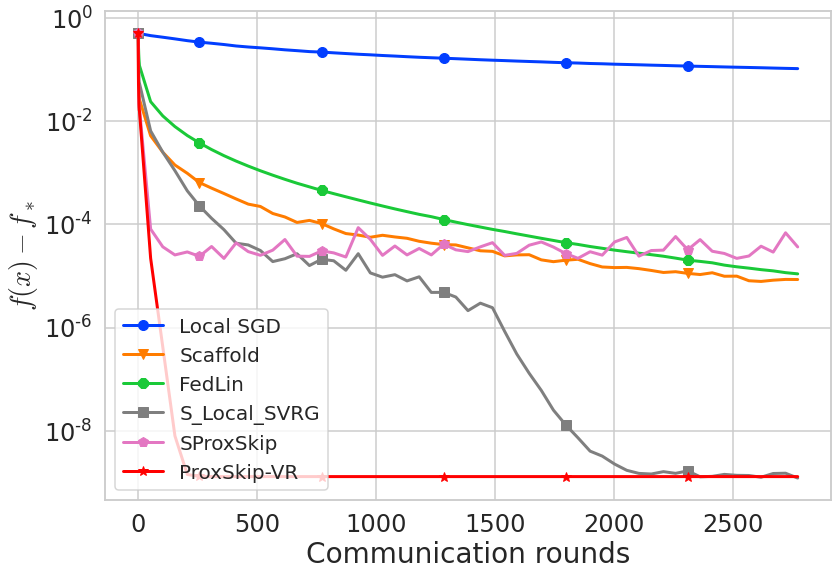

In [114]:
size = 30
markevery = 10
mcut = 60
skip_it = skip_it[:mcut]
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.labelsize'] = 24  # 40
plt.rcParams['ytick.labelsize'] = 24  # 40
plt.rcParams['legend.fontsize'] = 20  # 30
plt.rcParams['axes.titlesize'] = 28  # 40
plt.rcParams['axes.labelsize'] = 28  # 40
plt.rcParams["figure.figsize"] = [13, 9]
plt.yscale('log')
plt.ylabel(r'$f(x)-f_*$')
plt.xlabel('Communication rounds')
plt.grid(True)

sparse_k = 25
mit, msgd, mscah, mfedlin, msvrg, msproxip, mproxskip, mvrproxskip = [], [], [], [], [], [], [], []
for i in range(int(len(skip_it)/sparse_k)):
    mit.append(skip_it[sparse_k * i])
    msproxip.append(sproxskip_vals[sparse_k * i])
    # mproxskip.append(proxskip_vals[sparse_k * i])
    mvrproxskip.append(vr_proxskip_vals[sparse_k * i])
# # sskip.trace.plot_losses(label='SProxSkip', marker='+')
# # skip.trace.plot_losses(label='ProxSkip', marker='x')
# # vr_skip.trace.plot_losses(label='VR_ProxSkip', marker='*')
plt.plot(skip_it, sgd_vals[:mcut], label='Local SGD', marker='o', markevery=markevery)
plt.plot(skip_it, scah_vals[:mcut], label='Scaffold', marker='v', markevery=markevery)
plt.plot(skip_it, fedlin_vals[:mcut], label='FedLin', marker='8', markevery=markevery)
plt.plot(skip_it, s_local_svrg_vals[:mcut], label='S_Local_SVRG', marker='s', markevery=markevery, color='#7f7f7f')
plt.plot(skip_it, sproxskip_vals[:mcut], label='SProxSkip', marker='p', markevery=markevery, color='#e377c2')
# plt.plot(skip_it, proxskip_vals[:mcut], label='ProxSkip', marker='d', markevery=markevery, color='#9467bd')
plt.plot(skip_it, vr_proxskip_vals[:mcut], label='ProxSkip-VR', marker='*', markevery=markevery, color='red')
# plt.plot(mit, msproxip[:mcut], label='SProxSkip', marker='p', markevery=markevery, color='#e377c2')
# plt.plot(mit, mproxskip[:mcut], label='ProxSkip', marker='d', markevery=markevery, color='#9467bd')
# plt.plot(mit, mvrproxskip[:mcut], label='VR_ProxSkip', marker='*', markevery=markevery, color='red')
plt.legend()
plt.savefig(f'{file_name}_round.pdf')
plt.show()
plt.close()